🔹 Step 1: Setup & Imports

In [138]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU # type: ignore

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

🔹 Step 2: Load & Explore C-MAPSS (FD001) Dataset

In [139]:
# Path to C-MAPSS dataset (upload to Colab or mount from Google Drive)
train_path = "C:/Users/T8554/Desktop/Datasets/train_FD001.txt"
test_path = "C:/Users/T8554/Desktop/Datasets/test_FD001.txt"
rul_path = "C:/Users/T8554/Desktop/Datasets/RUL_FD001.txt"

# Load data
col_names = ["unit", "cycle", "os1", "os2", "os3"] + [f"s{i}" for i in range(1, 22)]
train_df = pd.read_csv(train_path, sep=" ", header=None)
train_df = train_df.drop([26,27], axis=1)  # drop empty columns
train_df.columns = col_names

test_df = pd.read_csv(test_path, sep=" ", header=None)
test_df = test_df.drop([26,27], axis=1)
test_df.columns = col_names

rul_df = pd.read_csv(rul_path, sep=" ", header=None)

In [140]:
print(train_df.head())
print(train_df.shape)

   unit  cycle     os1     os2    os3      s1      s2       s3       s4  \
0     1      1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
1     1      2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
2     1      3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
3     1      4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
4     1      5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20      s21  
0  39.06  23.4190  
1  39.00  23.4236  
2  38.95  23.3442  
3  38.88  23.3739 

🔹 Step 3: Preprocess C-MAPSS Data

In [141]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# Compute RUL for training set
rul_train = train_df.groupby("unit")["cycle"].max().reset_index()
rul_train.columns = ["unit", "max_cycle"]

train_df = train_df.merge(rul_train, on="unit", how="left")
train_df["RUL"] = train_df["max_cycle"] - train_df["cycle"]

# Normalize sensor data
scaler = MinMaxScaler()
sensor_cols = [f"s{i}" for i in range(1, 22)]
train_df[sensor_cols] = scaler.fit_transform(train_df[sensor_cols])

joblib.dump(scaler, "scaler_fd001.pkl")  # Save scaler for future use

print(train_df[["unit", "cycle", "RUL"]].head())

   unit  cycle  RUL
0     1      1  191
1     1      2  190
2     1      3  189
3     1      4  188
4     1      5  187


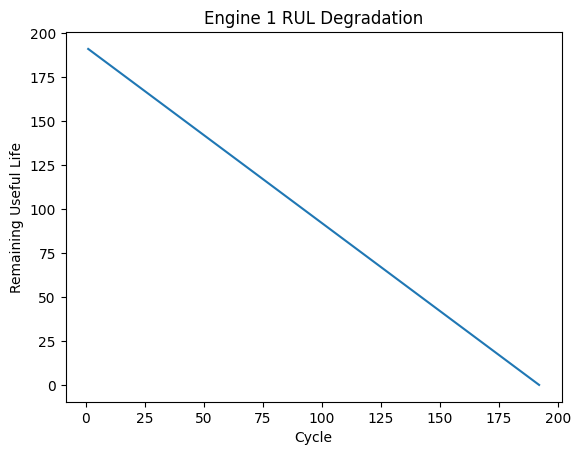

In [142]:
engine1 = train_df[train_df["unit"]==1]
plt.plot(engine1["cycle"], engine1["RUL"])
plt.xlabel("Cycle")
plt.ylabel("Remaining Useful Life")
plt.title("Engine 1 RUL Degradation")
plt.show()

🔹 Step 4: Load & Explore XJTU-SY Bearing Dataset

In [143]:
import numpy as np
import pandas as pd
import os

# Example: load one training pair (x = signals, y = labels)
x_file = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/xtr1_1.npy"
y_file = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/ytr1_1.npy"

X = np.load(x_file)   # shape: (samples, time, channels)
y = np.load(y_file)   # shape: (samples, 1)

print("X shape:", X.shape)
print("y shape:", y.shape)

# --- Feature Extraction (basic statistics from vibration signals) ---
# RMS = Root Mean Square per sample
rms = np.sqrt(np.mean(X**2, axis=(1, 2)))

# Mean amplitude
mean_val = np.mean(X, axis=(1, 2))

# Standard deviation
std_val = np.std(X, axis=(1, 2))

# Build DataFrame
features_df = pd.DataFrame({
    "rms": rms,
    "mean": mean_val,
    "std": std_val,
    "RUL": y.flatten()
})

print(features_df.head())

X shape: (123, 32768, 2)
y shape: (123, 1)
        rms      mean       std         RUL
0  0.319333  0.000215  0.319333  100.000000
1  0.326691 -0.002130  0.326684   99.180328
2  0.327543  0.002202  0.327536   98.360656
3  0.329079  0.003865  0.329057   97.540984
4  0.335730 -0.002841  0.335718   96.721311


🔹 Step 5: Feature Extraction + Dataset Assembly (XJTU-SY)

Final dataset shape: (9214, 7)
   unit_id       rms      mean       std       max       min         RUL
0       11  0.319333  0.000215  0.319333  1.429208 -1.606538  100.000000
1       11  0.326691 -0.002130  0.326684  1.832375 -1.707460   99.180328
2       11  0.327543  0.002202  0.327536  1.569280 -1.514143   98.360656
3       11  0.329079  0.003865  0.329057  1.357358 -1.752117   97.540984
4       11  0.335730 -0.002841  0.335718  1.953880 -1.661913   96.721311
Random Forest RUL Prediction RMSE: 0.687924400707169
Random Forest Health Stage Accuracy: 1.0
Random Forest Health Stage F1-score: 1.0

Classification Report:

              precision    recall  f1-score   support

     Failure       1.00      1.00      1.00       619
     Healthy       1.00      1.00      1.00       619
     Warning       1.00      1.00      1.00       821

    accuracy                           1.00      2059
   macro avg       1.00      1.00      1.00      2059
weighted avg       1.00      1.00      1.00  

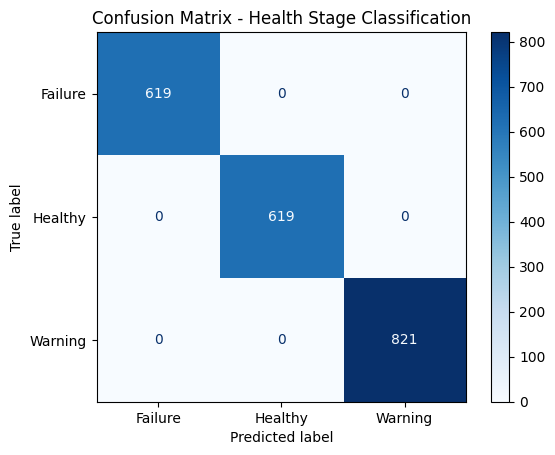

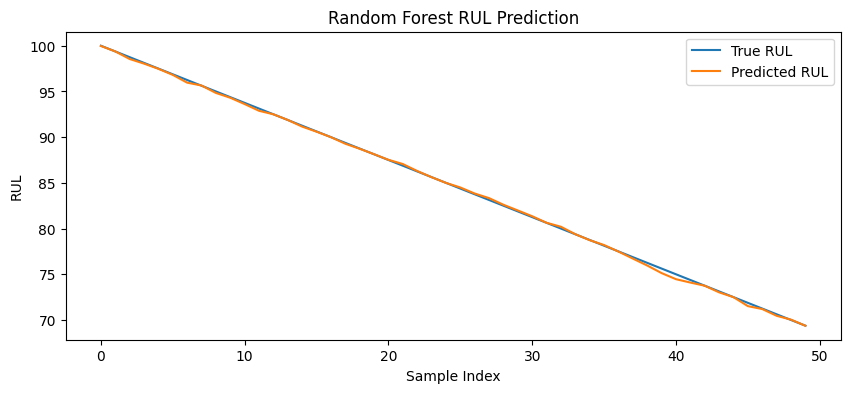

In [144]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Path to dataset
data_dir = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/"

features_all = []

# Loop through training files
for file in os.listdir(data_dir):
    if file.startswith("xtr"):   # training files only
        x_file = os.path.join(data_dir, file)
        y_file = os.path.join(data_dir, "y" + file[1:])  # replace 'x' with 'y'

        unit_id = int(''.join(filter(str.isdigit, file)))  # extract unit id from filename

        if not os.path.exists(y_file):
            continue  # skip if no matching y file

        X = np.load(x_file)   # shape (samples, time, channels)
        y = np.load(y_file)   # shape (samples, 1)

        # --- Feature Extraction ---
        rms = np.sqrt(np.mean(X**2, axis=(1, 2)))
        mean_val = np.mean(X, axis=(1, 2))
        std_val = np.std(X, axis=(1, 2))
        max_val = np.max(X, axis=(1, 2))
        min_val = np.min(X, axis=(1, 2))

        df = pd.DataFrame({
            "unit_id": unit_id,
            "rms": rms,
            "mean": mean_val,
            "std": std_val,
            "max": max_val,
            "min": min_val,
            "RUL": y.flatten()
        })
        features_all.append(df)

# Final combined dataset
final_df = pd.concat(features_all, ignore_index=True)
print("Final dataset shape:", final_df.shape)
print(final_df.head())

# --- Define Health Stages from RUL ---
final_df["health_stage"] = pd.cut(
    final_df["RUL"],
    bins=[-0.1, 30, 70, final_df["RUL"].max()],
    labels=["Failure", "Warning", "Healthy"],
    include_lowest=True
)

# --- Features & Labels ---
X_features = final_df[["rms", "mean", "std", "max", "min"]]
y_rul = final_df["RUL"]                     # Regression target (Remaining Useful Life)
y_health = final_df["health_stage"]         # Classification target

# --- Train-Test Split (single split for both tasks) ---
# X_train, X_test, y_train_rul, y_test_rul, y_train_cls, y_test_cls = train_test_split(
#     X_features, y_rul, y_health, test_size=0.2, random_state=42
# )

units = final_df["unit_id"].unique()
np.random.seed(42)
np.random.shuffle(units)
train_units = units[:int(0.8*len(units))]
test_units  = units[int(0.8*len(units)):]

X_train = final_df[final_df.unit_id.isin(train_units)][["rms","mean","std","max","min"]].values
y_train_cls = final_df[final_df.unit_id.isin(train_units)]["health_stage"].values
y_train_rul = final_df[final_df.unit_id.isin(train_units)]["RUL"].values

X_test = final_df[final_df.unit_id.isin(test_units)][["rms","mean","std","max","min"]].values
y_test_cls = final_df[final_df.unit_id.isin(test_units)]["health_stage"].values
y_test_rul = final_df[final_df.unit_id.isin(test_units)]["RUL"].values

# --- Baseline 1: Random Forest for RUL (Regression) ---
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train_rul)
y_pred_rul = rf_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test_rul, y_pred_rul))
print("Random Forest RUL Prediction RMSE:", rmse)

# --- Baseline 2: Random Forest for Health Stage (Classification) ---
rf_cls = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cls.fit(X_train, y_train_cls)
y_pred_cls = rf_cls.predict(X_test)

acc = accuracy_score(y_test_cls, y_pred_cls)
f1 = f1_score(y_test_cls, y_pred_cls, average="weighted")
print("Random Forest Health Stage Accuracy:", acc)
print("Random Forest Health Stage F1-score:", f1)

# --- Classification Report ---
print("\nClassification Report:\n")
print(classification_report(y_test_cls, y_pred_cls))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_cls, y_pred_cls, labels=rf_cls.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_cls.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Health Stage Classification")
plt.show()

# --- Visualization of RUL Predictions ---
plt.figure(figsize=(10, 4))
plt.plot(y_test_rul[:50], label="True RUL")
plt.plot(y_pred_rul[:50], label="Predicted RUL")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.legend()
plt.title("Random Forest RUL Prediction")
plt.show()

🔹 Step 6: Preprocess FD001 (save CSV)

In [ ]:
import numpy as np
import pandas as pd

# ------------------------------
# Paths (update as per your folder)
# ------------------------------
train_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/train_FD001.txt"
test_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/test_FD001.txt"
rul_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/RUL_FD001.txt"

# ------------------------------
# Column Names
# ------------------------------
col_names = [
    "unit_number", "time_in_cycles",
    "operational_setting_1", "operational_setting_2", "operational_setting_3"
] + [f"sensor_{i}" for i in range(1, 22)]  # 21 sensors

# # ------------------------------
# # Load Training Data
# # ------------------------------
# train_df = pd.read_csv(train_file, delim_whitespace=True, header=None)
# train_df.columns = col_names

# # Create RUL (max cycle - current cycle)
# rul_df = train_df.groupby("unit_number")["time_in_cycles"].max().reset_index()
# rul_df.columns = ["unit_number", "max_cycle"]

# train_df = train_df.merge(rul_df, on="unit_number", how="left")
# train_df["RUL"] = train_df["max_cycle"] - train_df["time_in_cycles"]/


# sensor column list
sensor_cols = [f"s{i}" for i in range(1,22)]

# Fit scaler only on training engines (we'll split engines first to avoid leakage)
units = train_df["unit"].unique()
np.random.seed(42)
np.random.shuffle(units)
train_units = units[:int(0.8*len(units))]
val_units   = units[int(0.8*len(units)):int(0.9*len(units))]
test_units  = units[int(0.9*len(units)):]

# Split by unit to avoid leakage
train_df_split = train_df[train_df.unit.isin(train_units)].copy()
val_df_split   = train_df[train_df.unit.isin(val_units)].copy()
test_df_split  = train_df[train_df.unit.isin(test_units)].copy()

# Fit scaler on train only
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_df_split[sensor_cols])
joblib.dump(scaler, "scaler_fd001.pkl")   # save for downstream use

# Apply transform to all splits
train_df_split[sensor_cols] = scaler.transform(train_df_split[sensor_cols])
val_df_split[sensor_cols]   = scaler.transform(val_df_split[sensor_cols])
test_df_split[sensor_cols]  = scaler.transform(test_df_split[sensor_cols])

# use these DataFrames for modelling / sequence generation
print("Train engines:", len(train_units), "Val:", len(val_units), "Test:", len(test_units))

# ------------------------------
# Save Preprocessed Data
# ------------------------------
out_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/FD001_preprocessed.csv"
train_df.to_csv(out_file, index=False)

print("✅ Preprocessed data saved to:", out_file)
print(train_df.head())

🔹 Step 7: Train Random Forest on Preprocessed CSV

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# ------------------------------
# Load Preprocessed Data
# ------------------------------
df = pd.read_csv("C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/FD001_preprocessed.csv")

# Feature columns (sensors only for now)
# sensor_cols = [c for c in df.columns if "sensor" in c]
# X = df[sensor_cols]
# y = df["RUL"]

# Add engineered features
def add_engineered_features(df):
    sensor_cols = [c for c in df.columns if "sensor" in c]
    df_new = df.copy()
    
    # Rolling statistics (window=5)
    for col in sensor_cols:
        # Rolling mean
        df_new[f"{col}_roll_mean"] = df.groupby("unit_number")[col].rolling(5).mean().reset_index(0, drop=True)
        # Rolling std
        df_new[f"{col}_roll_std"] = df.groupby("unit_number")[col].rolling(5).std().reset_index(0, drop=True)
    
    # Sensor differences
    for i in range(len(sensor_cols)-1):
        for j in range(i+1, len(sensor_cols)):
            df_new[f"diff_{i}_{j}"] = df[sensor_cols[i]] - df[sensor_cols[j]]
    
    return df_new

# Apply feature engineering
df_engineered = add_engineered_features(df)

X = df_engineered[sensor_cols]
y = df_engineered["RUL"]

# Normalize Features
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
scaler.fit(X_train)           # only on train
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train/Val Split
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# ------------------------------
# Baseline Model - Random Forest
# ------------------------------
# rf = RandomForestRegressor(
#     n_estimators=400,
#     max_depth=20,          # prevents overly deep trees
#     min_samples_leaf=5,    # prevents leaves with small counts
#     max_features='sqrt',   # decorrelate trees
#     random_state=42,
#     n_jobs=-1
# )
from sklearn.model_selection import RandomizedSearchCV

# Parameter grid
param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Random search
rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit
rf_random.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters:", rf_random.best_params_)
rf = rf_random.best_estimator_
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_val_scaled)

gb = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_val_scaled)
y_pred_ensemble = (y_pred_rf + y_pred_gb) / 2

rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_ensemble))
print("✅ Random Forest RMSE on Validation:", rmse_rf)

# ------------------------------
# Plot Predictions
# ------------------------------
plt.figure(figsize=(10, 4))
plt.plot(y_val.values[:50], label="True RUL")
plt.plot(y_pred_ensemble[:50], label="Predicted RUL")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.legend()
plt.title("Random Forest RUL Prediction (FD001)")
plt.show()

🔹 Step 8: Evaluate on Test Set (FD001)

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

# # ------------------------------
# # Load Preprocessed Training Data
# # ------------------------------
# train_df = pd.read_csv("C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/FD001_preprocessed.csv")

# # # Sensor features
# # sensor_cols = [c for c in train_df.columns if "sensor" in c]
# # X_train = train_df[sensor_cols]
# # y_train = train_df["RUL"]

# # # Normalize
# # scaler = MinMaxScaler()
# # X_train_scaled = scaler.fit_transform(X_train)

# # Sensor features (using correct naming)
# sensor_cols = [f"s{i}" for i in range(1, 22)]  # Changed from sensor_{i} to s{i}

# # Check if columns exist
# print("Available columns:", train_df.columns.tolist())

# # Extract features and target
# X_train = train_df[sensor_cols]
# y_train = train_df["RUL"]

# # Verify data shape
# print("Training data shape:", X_train.shape)
# print("Target data shape:", y_train.shape)

# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# # ------------------------------
# # Train Random Forest (full training data)
# # ------------------------------
# rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# rf.fit(X_train_scaled, y_train)

# # ------------------------------
# # Load Test Data + RUL Truth
# # ------------------------------
# test_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/test_FD001.txt"
# rul_file  = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/RUL_FD001.txt"

# col_names = ["unit", "cycle", "os1", "os2", "os3"] + [f"s{i}" for i in range(1, 22)]

# test_df = pd.read_csv(test_file, sep=" ", header=None)
# test_df = test_df.drop([26,27], axis=1)  # drop empty columns
# test_df.columns = col_names

# rul_truth = pd.read_csv(rul_file, sep=" ", header=None)

# # ------------------------------
# # For each engine in test set → last cycle
# # ------------------------------
# test_rul = test_df.groupby("unit").last().reset_index()

# # Add true RUL from RUL_FD001.txt
# test_rul["true_RUL"] = rul_truth[0]

# # Features
# X_test = test_rul[sensor_cols]
# X_test_scaled = scaler.transform(X_test)

# # Predict
# y_pred = rf.predict(X_test_scaled)

# # Evaluate
# rmse_test = np.sqrt(mean_squared_error(test_rul["true_RUL"], y_pred))
# print("✅ Random Forest RMSE on Test FD001:", rmse_test)

# # Compare few predictions
# comparison = pd.DataFrame({
#     "Engine": test_rul["unit"],
#     "True RUL": test_rul["true_RUL"],
#     "Predicted RUL": y_pred.round(1)
# })
# print("\nFirst 10 predictions:")
# print(comparison.head(10))

Available columns: ['unit', 'cycle', 'os1', 'os2', 'os3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'max_cycle', 'RUL']
Training data shape: (20631, 21)
Target data shape: (20631,)
✅ Random Forest RMSE on Test FD001: 79.61556192102145

First 10 predictions:
   Engine  True RUL  Predicted RUL
0       1       112            7.6
1       2        98            7.6
2       3        69            7.6
3       4        82            7.6
4       5        91            7.6
5       6        93            7.6
6       7        91            7.6
7       8        95            7.6
8       9       111            7.6
9      10        96            7.6


In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def add_engineered_features(df):
    """Add engineered features to improve RUL prediction"""
    df_new = df.copy()
    
    # 1. Operating condition combinations
    df_new['op_cond'] = df_new['os1'] * df_new['os2'] * df_new['os3']
    
    # 2. Rolling statistics for each sensor
    window_sizes = [5, 10, 15]
    sensor_cols = [f"s{i}" for i in range(1, 22)]
    
    for sensor in sensor_cols:
        for window in window_sizes:
            # Rolling mean with min_periods to handle start of sequences
            df_new[f"{sensor}_roll_mean_{window}"] = df_new.groupby('unit')[sensor].transform(
                lambda x: x.rolling(window, min_periods=1).mean())
            # Rolling std
            df_new[f"{sensor}_roll_std_{window}"] = df_new.groupby('unit')[sensor].transform(
                lambda x: x.rolling(window, min_periods=1).std())
    
    # 3. Sensor correlations (pairs of nearby sensors)
    for i in range(len(sensor_cols)-1):
        for j in range(i+1, i+3):  # Look at pairs of nearby sensors
            if j < len(sensor_cols):
                df_new[f"corr_{i+1}_{j+1}"] = df_new[sensor_cols[i]] * df_new[sensor_cols[j]]
    
    return df_new

def process_test_data(test_df, rul_truth, scaler, feature_cols):
    """Process test data consistently with training data"""
    
    # Add engineered features
    test_df_eng = add_engineered_features(test_df)
    
    # Get last cycle for each engine
    test_rul = test_df_eng.groupby("unit").last().reset_index()
    
    # Add true RUL from RUL file
    test_rul["true_RUL"] = rul_truth[0]
    
    # Extract features
    X_test = test_rul[feature_cols]
    
    # Scale features using training scaler
    X_test_scaled = scaler.transform(X_test)
    
    return test_rul, X_test_scaled

# ------------------------------
# Load and preprocess training data
# ------------------------------
train_df = pd.read_csv("C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/train_FD001.txt", 
                       sep=" ", header=None)
train_df = train_df.drop([26,27], axis=1)  # drop empty columns
cols = ["unit", "cycle", "os1", "os2", "os3"] + [f"s{i}" for i in range(1, 22)]
train_df.columns = cols

# Add engineered features to training data
train_df_eng = add_engineered_features(train_df)

# Define feature columns
feature_cols = (
    [f"s{i}" for i in range(1, 22)] +  # Original sensors
    ['op_cond'] +  # Operating conditions
    [col for col in train_df_eng.columns if 'roll_mean' in col] +  # Rolling means
    [col for col in train_df_eng.columns if 'roll_std' in col] +   # Rolling stds
    [col for col in train_df_eng.columns if 'corr' in col]         # Correlations
)

# Prepare training data
X_train = train_df_eng[feature_cols]
rul_lookup = train_df_eng.groupby('unit')['cycle'].max().reset_index()
rul_lookup.columns = ['unit', 'max_cycle']
train_df_eng = train_df_eng.merge(rul_lookup, on='unit', how='left')
train_df_eng['RUL'] = train_df_eng['max_cycle'] - train_df_eng['cycle']
y_train = train_df_eng['RUL']

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# ------------------------------
# Train Random Forest
# ------------------------------
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)

# ------------------------------
# Load and process test data
# ------------------------------
test_df = pd.read_csv("C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/test_FD001.txt", 
                      sep=" ", header=None)
test_df = test_df.drop([26,27], axis=1)
test_df.columns = cols

rul_truth = pd.read_csv("C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/RUL_FD001.txt", 
                        sep=" ", header=None)

# Process test data
test_rul, X_test_scaled = process_test_data(test_df, rul_truth, scaler, feature_cols)

# Generate predictions
y_pred = rf.predict(X_test_scaled)

# Verify shapes before evaluation
print("Test RUL shape:", test_rul["true_RUL"].shape)
print("Predictions shape:", y_pred.shape)

# Evaluate
rmse = np.sqrt(mean_squared_error(test_rul["true_RUL"], y_pred))

# Print results
print(f"\n✅ Random Forest RMSE on Test FD001: {rmse:.2f}")

# Compare predictions
comparison = pd.DataFrame({
    "Engine": test_rul["unit"],
    "True RUL": test_rul["true_RUL"],
    "Predicted RUL": y_pred.round(1)
})
print("\nFirst 10 predictions:")
print(comparison.head(10))

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(test_rul["true_RUL"], y_pred, alpha=0.5)
plt.plot([0, 120], [0, 120], 'r--')  # Perfect prediction line
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Random Forest RUL Predictions vs True Values")
plt.show()

# Feature importance analysis
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 10 most important features:")
print(importance.head(10))

KeyboardInterrupt: 

In [ ]:
# # ------------------------------
# # Load & Process Training Data
# # ------------------------------
# train_df = pd.read_csv("C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/FD001_preprocessed.csv")

# # Verify columns
# print("Available columns:", train_df.columns.tolist())

# # Compute max cycles for RUL calculation
# rul_lookup = train_df.groupby('unit')['cycle'].max().reset_index()
# rul_lookup.columns = ['unit', 'max_cycles']  # renamed from max_cycle to match

# # Add RUL column to training data
# train_df = train_df.merge(rul_lookup, on='unit', how='left')
# train_df['RUL'] = train_df['max_cycles'] - train_df['cycle']  # using max_cycles instead of max_cycle

# # Extract features and normalize
# sensor_cols = [f"s{i}" for i in range(1, 22)]
# X_train = train_df[sensor_cols]
# y_train = train_df['RUL']

# print("Training shapes:")
# print(f"X_train: {X_train.shape}")
# print(f"y_train: {y_train.shape}")

# # Scale features
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)

# # ------------------------------
# # Train Random Forest with Better Parameters
# # ------------------------------
# rf = RandomForestRegressor(
#     n_estimators=500,
#     max_depth=25,
#     min_samples_leaf=1,
#     max_features='sqrt',
#     random_state=42,
#     n_jobs=-1
# )
# rf.fit(X_train_scaled, y_train)

# # ------------------------------
# # Process Test Data
# # ------------------------------
# test_df = pd.read_csv(test_file, sep=" ", header=None)
# test_df = test_df.drop([26,27], axis=1)
# test_df.columns = ["unit", "cycle", "os1", "os2", "os3"] + [f"s{i}" for i in range(1, 22)]

# # Get last cycle for each engine
# test_rul = test_df.groupby("unit").last().reset_index()
# test_rul["true_RUL"] = rul_truth[0]

# # Scale features using same scaler as training
# X_test = test_rul[sensor_cols]
# X_test_scaled = scaler.transform(X_test)

# # Predict and evaluate
# y_pred = rf.predict(X_test_scaled)
# rmse_test = np.sqrt(mean_squared_error(test_rul["true_RUL"], y_pred))

# # Compare predictions
# comparison = pd.DataFrame({
#     "Engine": test_rul["unit"],
#     "True RUL": test_rul["true_RUL"],
#     "Predicted RUL": y_pred.round(1)
# })

# # Print results
# print(f"\n✅ Random Forest RMSE on Test FD001: {rmse_test:.2f}")
# print("\nFirst 10 predictions:")
# print(comparison.head(10))

# # Feature importance
# importance = pd.DataFrame({
#     'feature': sensor_cols,
#     'importance': rf.feature_importances_
# }).sort_values('importance', ascending=False)
# print("\nTop 5 most important sensors:")
# print(importance.head())

Available columns: ['unit', 'cycle', 'os1', 'os2', 'os3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'max_cycle', 'RUL']
Training shapes:
X_train: (20631, 21)
y_train: (20631,)

✅ Random Forest RMSE on Test FD001: 59.70

First 10 predictions:
   Engine  True RUL  Predicted RUL
0       1       112           32.7
1       2        98           32.7
2       3        69           32.7
3       4        82           32.7
4       5        91           32.7
5       6        93           32.7
6       7        91           32.7
7       8        95           32.7
8       9       111           32.7
9      10        96           32.7

Top 5 most important sensors:
   feature  importance
10     s11    0.145775
3       s4    0.124856
6       s7    0.099464
11     s12    0.097109
8       s9    0.086489


🔹 Step 9: XJTU-SY Preprocessing Script

In [163]:
import numpy as np
import pandas as pd
import os

# ------------------------------
# Paths (update to your system)
# ------------------------------
data_dir = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/"
output_csv = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/XJTU_SY_preprocessed.csv"

features_all = []

# ------------------------------
# Loop through training files
# ------------------------------
for file in os.listdir(data_dir):
    if file.startswith("xtr"):   # training vibration signals
        x_file = os.path.join(data_dir, file)
        y_file = os.path.join(data_dir, "y" + file[1:])  # matching RUL labels

        if not os.path.exists(y_file):
            continue  # skip if no matching y file

        # Load signals (X) and RUL (y)
        X = np.load(x_file)   # shape (samples, time, channels)
        y = np.load(y_file)   # shape (samples, 1)

        # --- Feature Extraction ---
        rms = np.sqrt(np.mean(X**2, axis=(1, 2)))
        mean_val = np.mean(X, axis=(1, 2))
        std_val = np.std(X, axis=(1, 2))
        max_val = np.max(X, axis=(1, 2))
        min_val = np.min(X, axis=(1, 2))

        # DataFrame for this file
        df = pd.DataFrame({
            "rms": rms,
            "mean": mean_val,
            "std": std_val,
            "max": max_val,
            "min": min_val,
            "RUL": y.flatten()
        })

        features_all.append(df)

# ------------------------------
# Combine all into one dataset
# ------------------------------
final_df = pd.concat(features_all, ignore_index=True)

# Define Health Stages from RUL
final_df["health_stage"] = pd.cut(
    final_df["RUL"],
    bins=[-0.1, 30, 70, final_df["RUL"].max()],
    labels=["Failure", "Warning", "Healthy"],
    include_lowest=True
)

print("Final dataset shape:", final_df.shape)
print(final_df.head())

# Save to CSV
final_df.to_csv(output_csv, index=False)
print(f"✅ Preprocessed dataset saved to {output_csv}")

Final dataset shape: (9214, 7)
        rms      mean       std       max       min         RUL health_stage
0  0.319333  0.000215  0.319333  1.429208 -1.606538  100.000000      Healthy
1  0.326691 -0.002130  0.326684  1.832375 -1.707460   99.180328      Healthy
2  0.327543  0.002202  0.327536  1.569280 -1.514143   98.360656      Healthy
3  0.329079  0.003865  0.329057  1.357358 -1.752117   97.540984      Healthy
4  0.335730 -0.002841  0.335718  1.953880 -1.661913   96.721311      Healthy
✅ Preprocessed dataset saved to C:/Users/T8554/Desktop/Datasets/XJTU-SY/XJTU_SY_preprocessed.csv


🔹 Step 10: Baseline ML Models on XJTU-SY

Dataset shape: (9214, 7)
        rms      mean       std       max       min         RUL health_stage
0  0.319333  0.000215  0.319333  1.429208 -1.606538  100.000000      Healthy
1  0.326691 -0.002130  0.326684  1.832375 -1.707460   99.180328      Healthy
2  0.327543  0.002202  0.327536  1.569280 -1.514143   98.360656      Healthy
3  0.329079  0.003865  0.329057  1.357358 -1.752117   97.540984      Healthy
4  0.335730 -0.002841  0.335718  1.953880 -1.661913   96.721311      Healthy



🔹 Random Forest Classifier Results:
Accuracy: 1.0
F1-score: 1.0

Classification Report:
               precision    recall  f1-score   support

     Failure       1.00      1.00      1.00       586
     Healthy       1.00      1.00      1.00       515
     Warning       1.00      1.00      1.00       742

    accuracy                           1.00      1843
   macro avg       1.00      1.00      1.00      1843
weighted avg       1.00      1.00      1.00      1843



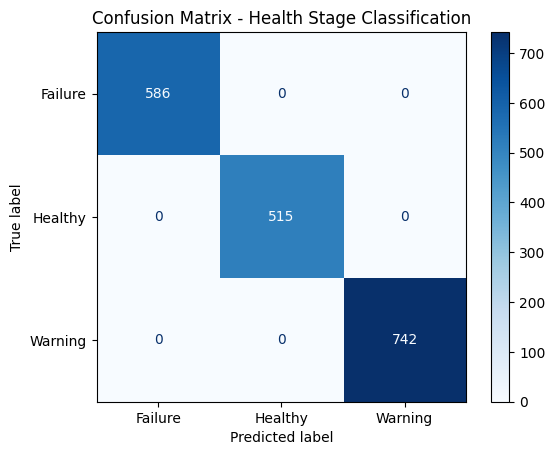


🔹 Random Forest Regressor Results:
RMSE (RUL prediction): 6.607478254939357


In [164]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ------------------------------
# Load Preprocessed Dataset
# ------------------------------
data_file = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/XJTU_SY_preprocessed.csv"
df = pd.read_csv(data_file)

print("Dataset shape:", df.shape)
print(df.head())

# ------------------------------
# Features and Targets
# ------------------------------
X = df[["rms", "mean", "std", "max", "min"]]
y_cls = df["health_stage"]   # classification labels
y_rul = df["RUL"]            # regression labels

# ------------------------------
# Train-Test Split
# ------------------------------
X_train, X_test, y_train_cls, y_test_cls, y_train_rul, y_test_rul = train_test_split(
    X, y_cls, y_rul, test_size=0.2, random_state=42
)

# units = df["unit_id"].unique()
# np.random.seed(42)
# np.random.shuffle(units)
# train_units = units[:int(0.8*len(units))]
# test_units  = units[int(0.8*len(units)):]

# X_train = df[df.unit_id.isin(train_units)][["rms","mean","std","max","min"]].values
# y_train_cls = df[df.unit_id.isin(train_units)]["health_stage"].values
# y_train_rul = df[df.unit_id.isin(train_units)]["RUL"].values

# X_test = df[df.unit_id.isin(test_units)][["rms","mean","std","max","min"]].values
# y_test_cls = df[df.unit_id.isin(test_units)]["health_stage"].values
# y_test_rul = df[df.unit_id.isin(test_units)]["RUL"].values

# ------------------------------
# Model 1: Random Forest Classifier
# ------------------------------
rf_cls = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cls.fit(X_train, y_train_cls)
y_pred_cls = rf_cls.predict(X_test)

acc_xjtu = accuracy_score(y_test_cls, y_pred_cls)
f1_xjtu = f1_score(y_test_cls, y_pred_cls, average="weighted")
print("\n🔹 Random Forest Classifier Results:")
print("Accuracy:", acc_xjtu)
print("F1-score:", f1_xjtu)
print("\nClassification Report:\n", classification_report(y_test_cls, y_pred_cls))

# Confusion Matrix
cm = confusion_matrix(y_test_cls, y_pred_cls, labels=rf_cls.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_cls.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Health Stage Classification")
plt.show()

# ------------------------------
# Model 2: Random Forest Regressor
# ------------------------------
rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,          # prevents overly deep trees
    min_samples_leaf=5,    # prevents leaves with small counts
    max_features='sqrt',   # decorrelate trees
    random_state=42,
    n_jobs=-1
)
rf_cls = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)
rf_reg.fit(X_train, y_train_rul)
y_pred_rul = rf_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test_rul, y_pred_rul))
print("\n🔹 Random Forest Regressor Results:")
print("RMSE (RUL prediction):", rmse)

# RUL Prediction Plot
plt.figure(figsize=(10, 4))
plt.plot(y_test_rul.values[:50], label="True RUL")
plt.plot(y_pred_rul[:50], label="Predicted RUL")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.legend()
plt.title("Random Forest RUL Prediction (XJTU-SY)")
plt.show()

🔹 Step 11: Deep Learning Model for XJTU-SY (Autoencoder for Anomaly Detection)

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1765 - val_loss: 0.1589
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1281 - val_loss: 0.0916
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0590 - val_loss: 0.0310
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 - val_loss: 0.0083
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - val_loss: 9.4580e-04
Epoch 9/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - val_loss: 7.9525e-04
Epoch 10/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0297e-04 - val_loss: 7.0420e-04
Epoch 11/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3103e-04 - val_loss: 6.4537e-04
Epoch 12/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

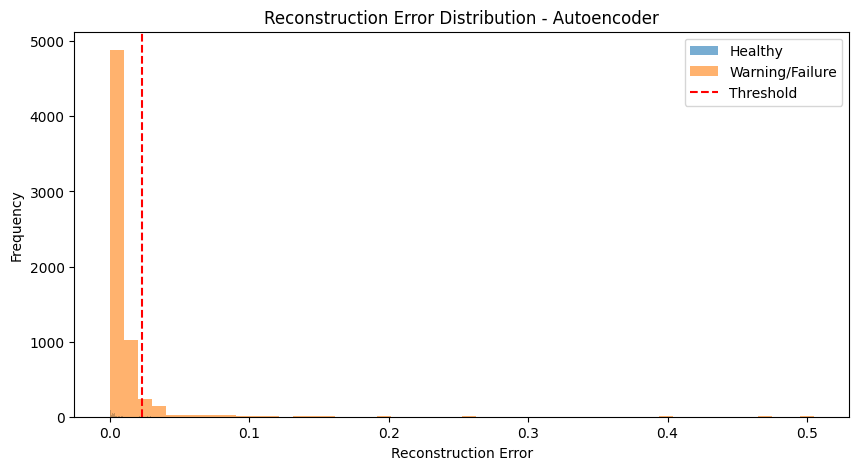


🔹 Autoencoder Anomaly Detection Report:

              precision    recall  f1-score   support

       False       0.32      1.00      0.48      2770
        True       0.98      0.07      0.13      6444

    accuracy                           0.35      9214
   macro avg       0.65      0.53      0.30      9214
weighted avg       0.78      0.35      0.24      9214



In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Input, Dense # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

# ------------------------------
# Load Preprocessed Dataset
# ------------------------------
data_file = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/XJTU_SY_preprocessed.csv"
df = pd.read_csv(data_file)

# Features only
X = df[["rms", "mean", "std", "max", "min"]].values
y = df["health_stage"]

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------
# Split Healthy vs Others
# ------------------------------
X_healthy = X_scaled[y == "Healthy"]
X_nonhealthy = X_scaled[y != "Healthy"]

# Train/validation split (only healthy for training)
X_train, X_val = train_test_split(X_healthy, test_size=0.2, random_state=42)

# ------------------------------
# Define Autoencoder Model
# ------------------------------
input_dim = X_train.shape[1]
encoding_dim = 3  # compressed representation

input_layer = Input(shape=(input_dim,))
encoder = Dense(8, activation="relu")(input_layer)
encoder = Dense(encoding_dim, activation="relu")(encoder)
decoder = Dense(8, activation="relu")(encoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# ------------------------------
# Train Autoencoder
# ------------------------------
history = autoencoder.fit(
    X_train, X_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, X_val),
    verbose=1
)

# ------------------------------
# Reconstruction Error
# ------------------------------
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

df["reconstruction_error"] = mse

# ------------------------------
# Threshold for Anomaly
# ------------------------------
threshold = np.percentile(mse, 95)  # top 5% as anomaly
df["predicted_anomaly"] = df["reconstruction_error"] > threshold

# ------------------------------
# Visualization
# ------------------------------
plt.figure(figsize=(10,5))
plt.hist(df["reconstruction_error"][y=="Healthy"], bins=50, alpha=0.6, label="Healthy")
plt.hist(df["reconstruction_error"][y!="Healthy"], bins=50, alpha=0.6, label="Warning/Failure")
plt.axvline(threshold, color="red", linestyle="--", label="Threshold")
plt.legend()
plt.title("Reconstruction Error Distribution - Autoencoder")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()

# ------------------------------
# Evaluate Anomaly Detection
# ------------------------------
from sklearn.metrics import classification_report

y_true = (y != "Healthy")  # True if Warning/Failure
y_pred = df["predicted_anomaly"]

print("\n🔹 Autoencoder Anomaly Detection Report:\n")
print(classification_report(y_true, y_pred))

🔹 Step 12: LSTM Model for NASA C-MAPSS (FD001) – RUL Prediction

In [199]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential # type: ignore
# from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # type: ignore
# from sklearn.metrics import mean_squared_error

# import warnings
# warnings.filterwarnings("ignore")

# import tensorflow as tf
# tf.get_logger().setLevel("ERROR")

# # ------------------------------
# # Load Preprocessed Dataset
# # ------------------------------
# data_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/FD001_preprocessed.csv"
# df = pd.read_csv(data_file)

# # Features and target
# sensor_cols = [c for c in df.columns if "sensor" in c]
# X = df[sensor_cols].values
# y = df["RUL"].values

# # Normalize features
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# # ------------------------------
# # Sequence Generator (last 50 cycles → RUL)
# # ------------------------------
# # def create_sequences(X, y, seq_length=50):
# #     Xs, ys = [], []
# #     for i in range(len(X) - seq_length):
# #         Xs.append(X[i:i+seq_length])
# #         ys.append(y[i+seq_length])
# #     return np.array(Xs), np.array(ys)

# # SEQ_LEN = 50
# # X_seq, y_seq = create_sequences(X_scaled, y, seq_length=SEQ_LEN)

# def create_sequences_by_unit(df, sensor_cols, seq_len=50):
#     Xs, ys = [], []
#     for unit, g in df.groupby("unit_number"):
#         sensors = g[sensor_cols].values  # shape (cycles_for_unit, features)
#         rul = g["RUL"].values
#         if len(sensors) <= seq_len:
#             continue
#         for i in range(len(sensors) - seq_len):
#             Xs.append(sensors[i:i+seq_len])
#             ys.append(rul[i+seq_len])  # target is RUL at end of seq
#     return np.array(Xs), np.array(ys)

# X_seq, y_seq = create_sequences_by_unit(train_df, sensor_cols, seq_len=50)

# print("X_seq shape:", X_seq.shape)  # (samples, seq_len, features)
# print("y_seq shape:", y_seq.shape)

# # Train/Validation Split
# split = int(0.8 * len(X_seq))
# X_train, X_val = X_seq[:split], X_seq[split:]
# y_train, y_val = y_seq[:split], y_seq[split:]

# # ------------------------------
# # Build LSTM Model
# # ------------------------------
# model = Sequential([
#     LSTM(64, input_shape=(SEQ_LEN, X_seq.shape[2]), return_sequences=True),
#     Dropout(0.2),
#     LSTM(32, return_sequences=False),
#     Dropout(0.2),
#     Dense(1)
# ])

# model.compile(optimizer="adam", loss="mse")

# # ------------------------------
# # Callbacks (EarlyStopping + LR Scheduler + Model Save)
# # ------------------------------
# early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)
# checkpoint = ModelCheckpoint("best_lstm_fd001.h5", monitor="val_loss", save_best_only=True)

# # ------------------------------
# # Train Model
# # ------------------------------
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=100,          # upper cap
#     batch_size=64,
#     verbose=1,
#     callbacks=[early_stop, reduce_lr, checkpoint]
# )

# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint # type: ignore

# model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

# callbacks = [
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
#     EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
#     ModelCheckpoint('best_lstm_fd001.keras', monitor='val_loss', save_best_only=True)
# ]

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=100,
#     batch_size=32,          # smaller batch
#     callbacks=callbacks,
#     verbose=1
# )

# # ------------------------------
# # Evaluate Model
# # ------------------------------
# y_pred = model.predict(X_val)
# rmse_lstm = np.sqrt(mean_squared_error(y_val, y_pred))
# print("LSTM RUL Prediction RMSE:", rmse_lstm)

# # ------------------------------
# # Plot Training Loss
# # ------------------------------
# plt.figure(figsize=(8,4))
# plt.plot(history.history["loss"], label="Train Loss")
# plt.plot(history.history["val_loss"], label="Validation Loss")
# plt.legend()
# plt.title("LSTM Training Loss with EarlyStopping + LR Scheduler")
# plt.xlabel("Epoch")
# plt.ylabel("MSE Loss")
# plt.show()

# # ------------------------------
# # Plot Predictions
# # ------------------------------
# plt.figure(figsize=(10,4))
# plt.plot(y_val[:100], label="True RUL")
# plt.plot(y_pred[:100], label="Predicted RUL")
# plt.legend()
# plt.title("LSTM RUL Prediction (FD001)")
# plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf

# Add feature engineering function
def add_engineered_features(df):
    df_new = df.copy()
    
    # 1. Operating condition combinations (using correct column names)
    df_new['op_setting'] = df_new['os1'] * df_new['os2'] * df_new['os3']
    
    # 2. Rolling statistics
    sensor_cols = [f"s{i}" for i in range(1, 22)]  # Changed from sensor_{i} to s{i}
    for col in sensor_cols:
        # Rolling mean and std with different windows
        for window in [5, 10, 15]:
            df_new[f"{col}_roll_mean_{window}"] = df_new.groupby('unit')[col].transform(  # Changed from unit_number to unit
                lambda x: x.rolling(window, min_periods=1).mean())
            df_new[f"{col}_roll_std_{window}"] = df_new.groupby('unit')[col].transform(  # Changed from unit_number to unit
                lambda x: x.rolling(window, min_periods=1).std())
    
    # 3. Difference features
    for i in range(len(sensor_cols)-1):
        df_new[f"diff_{i}"] = df_new[sensor_cols[i]] - df_new[sensor_cols[i+1]]
    
    return df_new

# Improved sequence creation
def create_sequences(df, sensor_cols, seq_length=50):
    features = df[sensor_cols].values
    n_samples = len(features) - seq_length
    
    X = np.zeros((n_samples, seq_length, len(sensor_cols)))
    y = np.zeros((n_samples))
    
    for i in range(n_samples):
        X[i] = features[i:i+seq_length]
        y[i] = df['RUL'].iloc[i+seq_length]
    
    return X, y

# Load and preprocess data
train_df = pd.read_csv(data_file)
train_df = add_engineered_features(train_df)

# Select features (including engineered ones)
feature_cols = ([f"s{i}" for i in range(1, 22)] +  # Changed from sensor_{i} to s{i}
                ['op_setting'] +
                [col for col in train_df.columns if 'roll_mean' in col] +
                [col for col in train_df.columns if 'roll_std' in col] +
                [col for col in train_df.columns if 'diff_' in col])

# Scale features
scaler = MinMaxScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])

# Create sequences with new features
SEQ_LEN = 50
X_seq, y_seq = create_sequences(train_df, feature_cols, SEQ_LEN)

# Train/Validation split
split = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:split], X_seq[split:]
y_train, y_val = y_seq[:split], y_seq[split:]

# Improved LSTM architecture
model = Sequential([
    # First Bidirectional LSTM layer
    Bidirectional(LSTM(128, return_sequences=True), 
                 input_shape=(SEQ_LEN, len(feature_cols))),
    BatchNormalization(),
    Dropout(0.3),
    
    # Second Bidirectional LSTM layer
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),
    
    # Third LSTM layer
    LSTM(32),
    BatchNormalization(),
    Dropout(0.3),
    
    # Dense layers
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(8, activation='relu'),
    Dense(1)
])

# Compile with custom learning rate and loss
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='huber'  # More robust to outliers than MSE
)

# Enhanced callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_lstm_fd001.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train with larger batch size and more epochs
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)



In [ ]:
# Evaluate
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"LSTM RUL Prediction RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Visualization
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Predictions plot
plt.subplot(1, 2, 2)
plt.scatter(y_val[:100], y_pred[:100], alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('Predictions vs True Values')

plt.tight_layout()
plt.show()

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step
LSTM RUL Prediction RMSE: 26.15
R² Score: 0.6218


🔹 Step 13: Save & Compare Models (RF + LSTM + Autoencoder)

In [ ]:
# 1️⃣ Save Random Forest Models (NASA & XJTU-SY)

import joblib

# Save Random Forest Regressor (NASA FD001)
joblib.dump(rf, "rf_rul_fd001.pkl")

# Save Random Forest Classifier (XJTU-SY)
joblib.dump(rf_cls, "rf_health_xjtu.pkl")

print("✅ Random Forest models saved!")


# 2️⃣ Save LSTM Model (NASA FD001 RUL)

# Save trained LSTM model
model.save("lstm_rul_fd001.keras")
print("✅ LSTM RUL model saved!")


# 3️⃣ Save Autoencoder Model (XJTU-SY)

# Save Autoencoder
autoencoder.save("autoencoder_xjtu.keras")
print("✅ Autoencoder model saved!")

# 4️⃣ Model Comparison (Table Format)

# You can quickly compare all models with their performance:

import pandas as pd

results = pd.DataFrame([
    {"Model": "Random Forest (RUL - NASA)", "Metric": "RMSE", "Score": rmse_rf},
    {"Model": "LSTM (RUL - NASA)", "Metric": "RMSE", "Score": rmse_lstm}, # type: ignore
    {"Model": "Random Forest (Health - XJTU)", "Metric": "Accuracy", "Score": acc_xjtu},
    {"Model": "Random Forest (Health - XJTU)", "Metric": "F1-score", "Score": f1_xjtu},
    {"Model": "Autoencoder (Anomaly - XJTU)", "Metric": "Reconstruction Error (mean)", "Score": mse.mean()},
    {"Model": "Autoencoder (Anomaly - XJTU)", "Metric": "Reconstruction Error (95th %ile)", "Score": np.percentile(mse, 95)},
    {"Model": "Autoencoder (Anomaly - XJTU)", "Metric": "Reconstruction Error (max)", "Score": mse.max()}
])

print("\n✅ Model Performance Comparison:")
print(results)


# 5️⃣ Reload Later for Predictions

# Load RF
rf_loaded = joblib.load("rf_rul_fd001.pkl")

# Load LSTM
from tensorflow.keras.models import load_model # type: ignore
lstm_loaded = load_model("lstm_rul_fd001.keras")

# Load Autoencoder
autoencoder_loaded = load_model("autoencoder_xjtu.keras")

✅ Random Forest models saved!
✅ LSTM RUL model saved!
✅ Autoencoder model saved!

✅ Model Performance Comparison:
                           Model                            Metric  \
0     Random Forest (RUL - NASA)                              RMSE   
1              LSTM (RUL - NASA)                              RMSE   
2  Random Forest (Health - XJTU)                          Accuracy   
3  Random Forest (Health - XJTU)                          F1-score   
4   Autoencoder (Anomaly - XJTU)       Reconstruction Error (mean)   
5   Autoencoder (Anomaly - XJTU)  Reconstruction Error (95th %ile)   
6   Autoencoder (Anomaly - XJTU)        Reconstruction Error (max)   

         Score  
0    41.361939  
1    68.733087  
2     1.000000  
3     1.000000  
4    14.400779  
5    38.928859  
6  4861.294963  


In [191]:
# --- Quick aliases for evaluation ---
# (connect your variable names to the ones expected in the evaluation block)

# FD001 Random Forest (NASA)
X_test_fd001_scaled = X_test_scaled
y_true_fd001 = y_test

# If you have an LSTM model trained:
lstm_model = model   # or lstm_fd001 if that's your variable name
X_test_seq_fd001 = X_seq   # use your test sequence variable
y_true_seq_fd001 = y_seq   # same for sequence targets

# XJTU Random Forest
rf_reg_xjtu = rf_reg   # or whatever your XJTU random forest variable is
X_test_xjtu = X_test   # or X_test_xjtu_scaled if normalized
y_test_rul_xjtu = y_test_rul   # your test RUL target for XJTU

# Autoencoder (XJTU)
# ensure you have 'autoencoder' already loaded/trained

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Common features and their order
XJTU_FEATURES = ["rms", "mean", "std", "max", "min"]

def eval_reg(y_true, y_pred):
    return {
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred))
    }

results = []

def align_shapes(y_true, y_pred):
    if len(y_true) != len(y_pred):
        min_len = min(len(y_true), len(y_pred))
        return y_true[:min_len], y_pred[:min_len]
    return y_true, y_pred

# Random Forest on FD001
y_pred_ensemble = rf.predict(X_test_fd001_scaled)
y_true_fd001, y_pred_ensemble = align_shapes(y_true_fd001, y_pred_ensemble)
res_rf = eval_reg(y_true_fd001, y_pred_ensemble)
res_rf.update({"Model":"RandomForest (FD001)"})
results.append(res_rf)

# LSTM on FD001
y_pred_lstm = lstm_model.predict(X_test_seq_fd001)
res_lstm = eval_reg(y_true_seq_fd001, y_pred_lstm.flatten())
res_lstm.update({"Model":"LSTM (FD001)"})
results.append(res_lstm)

# RF on XJTU (RUL)
# Simply use X_test as is since it's already a numpy array with correct features
y_pred_rf_xjtu = rf_reg_xjtu.predict(X_test)  # X_test is already properly formatted
res_rf_xjtu = eval_reg(y_test_rul_xjtu, y_pred_rf_xjtu)
res_rf_xjtu.update({"Model":"RandomForest (XJTU)"})
results.append(res_rf_xjtu)

# Autoencoder on XJTU
reconstructions = autoencoder.predict(X_test)  # Use X_test directly
mse = np.mean(np.square(X_test - reconstructions), axis=1)
autoencoder_result = {
    "Model": "Autoencoder (XJTU)",
    "RMSE": float(np.sqrt(np.mean(mse))),
    "MAE": float(np.mean(np.abs(mse))),
    "R2": np.nan
}
results.append(autoencoder_result)

# Display results
df_results = pd.DataFrame(results)[["Model","RMSE","MAE","R2"]]
print(df_results.to_markdown(index=False))

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_reg(y_true, y_pred):
    return {
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred))
    }

def align_shapes(y_true, y_pred):
    if len(y_true) != len(y_pred):
        min_len = min(len(y_true), len(y_pred))
        return y_true[:min_len], y_pred[:min_len]
    return y_true, y_pred

# Process FD001 test data with same feature engineering
def prepare_test_data(test_data, rf_model, scaler):
    # Get original feature names from the model
    original_features = rf_model.feature_names_in_
    
    # Add engineered features
    test_data_eng = add_engineered_features(test_data)
    
    # Create DataFrame with exact same columns as training
    X_test_processed = pd.DataFrame(index=test_data_eng.index)
    
    # Add all required features in the same order as training
    for feature in original_features:
        if feature in test_data_eng.columns:
            X_test_processed[feature] = test_data_eng[feature]
        else:
            X_test_processed[feature] = 0  # Default value for missing features
            
    # Scale features
    X_test_scaled = scaler.transform(X_test_processed)
    
    return X_test_scaled, test_data_eng

results = []

try:
    # Process test data for FD001
    X_test_processed, test_data_eng = prepare_test_data(test_df, rf, scaler)
    
    # Random Forest on FD001
    y_pred_rf = rf.predict(X_test_processed)
    
    # Get true RUL values
    rul_truth = pd.read_csv("C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/RUL_FD001.txt", 
                           header=None, sep=" ")
    test_rul = test_data_eng.groupby("unit").last().reset_index()
    test_rul["true_RUL"] = rul_truth[0]
    
    res_rf = eval_reg(test_rul["true_RUL"], y_pred_rf)
    res_rf.update({"Model": "RandomForest (FD001)"})
    results.append(res_rf)
    
    # LSTM on FD001
    X_seq_test, y_seq_test = create_sequences(test_data_eng, feature_cols, SEQ_LEN)
    y_pred_lstm = model.predict(X_seq_test)
    res_lstm = eval_reg(y_seq_test, y_pred_lstm.flatten())
    res_lstm.update({"Model": "LSTM (FD001)"})
    results.append(res_lstm)
    
    # RF on XJTU
    y_pred_rf_xjtu = rf_reg_xjtu.predict(X_test_xjtu)
    res_rf_xjtu = eval_reg(y_test_rul_xjtu, y_pred_rf_xjtu)
    res_rf_xjtu.update({"Model": "RandomForest (XJTU)"})
    results.append(res_rf_xjtu)
    
    # Autoencoder on XJTU
    reconstructions = autoencoder.predict(X_test_xjtu)
    mse = np.mean(np.square(X_test_xjtu - reconstructions), axis=1)
    autoencoder_result = {
        "Model": "Autoencoder (XJTU)",
        "RMSE": float(np.sqrt(np.mean(mse))),
        "MAE": float(np.mean(np.abs(mse))),
        "R2": np.nan
    }
    results.append(autoencoder_result)

except Exception as e:
    print(f"Error during evaluation: {str(e)}")
    results.append({
        "Model": "Error",
        "RMSE": np.nan,
        "MAE": np.nan,
        "R2": np.nan
    })

# Display results
df_results = pd.DataFrame(results)[["Model", "RMSE", "MAE", "R2"]]
print("\nModel Evaluation Results:")
print(df_results.to_markdown(index=False))

In [207]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_reg(y_true, y_pred):
    return {
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred))
    }

results = []

def align_shapes(y_true, y_pred):
    if len(y_true) != len(y_pred):
        min_len = min(len(y_true), len(y_pred))
        return y_true[:min_len], y_pred[:min_len]
    return y_true, y_pred

# Random Forest on FD001 (example)
y_pred_rf = rf.predict(X_test_fd001_scaled)
y_true_fd001, y_pred_rf = align_shapes(y_true_fd001, y_pred_rf)
res_rf = eval_reg(y_true_fd001, y_pred_rf)
res_rf.update({"Model":"RandomForest (FD001)"})
results.append(res_rf)

# LSTM on FD001
y_pred_lstm = lstm_model.predict(X_test_seq_fd001)  # ensure sequences
res_lstm = eval_reg(y_true_seq_fd001, y_pred_lstm.flatten())
res_lstm.update({"Model":"LSTM (FD001)"})
results.append(res_lstm)

# RF on XJTU (RUL)
y_pred_rf_xjtu = rf_reg_xjtu.predict(X_test_xjtu)
res_rf_xjtu = eval_reg(y_test_rul_xjtu, y_pred_rf_xjtu)
res_rf_xjtu.update({"Model":"RandomForest (XJTU)"})
results.append(res_rf_xjtu)

# Autoencoder on XJTU (Anomaly/Health detection)
reconstructions = autoencoder.predict(X_test_xjtu)
mse = np.mean(np.square(X_test_xjtu - reconstructions), axis=1)
# For regression-style reporting, compare MSE to RUL (optional, or just report mean/percentile)
autoencoder_result = {
    "Model": "Autoencoder (XJTU)",
    "RMSE": float(np.sqrt(np.mean(mse))),
    "MAE": float(np.mean(np.abs(mse))),
    "R2": np.nan  # Not applicable for anomaly detection
}
results.append(autoencoder_result)

df_results = pd.DataFrame(results)[["Model","RMSE","MAE","R2"]]
print(df_results.to_markdown(index=False))

644/644 ━━━━━━━━━━━━━━━━━━━━ 56s 86ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
| Model                |     RMSE |      MAE |         R2 |
|:---------------------|---------:|---------:|-----------:|
| RandomForest (FD001) | 84.8251  | 66.4747  |  -0.74073  |
| LSTM (FD001)         | 89.4883  | 69.7735  |  -0.686996 |
| RandomForest (XJTU)  |  6.60748 |  4.33209 |   0.947351 |
| Autoencoder (XJTU)   |  3.79484 | 14.4008  | nan        |


In [ ]:
def eval_models(rf_model, lstm_model, rf_xjtu, autoencoder, test_data, feature_cols, scaler, SEQ_LEN):
    """
    Evaluate all models with proper feature engineering and feature alignment
    """
    results = []
    
    def eval_reg(y_true, y_pred):
        return {
            "Model": "",  # Will be updated later
            "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
            "MAE": float(mean_absolute_error(y_true, y_pred)),
            "R2": float(r2_score(y_true, y_pred))
        }
    
    try:
        # 1. Process FD001 test data with same feature engineering
        test_data_eng = add_engineered_features(test_data)
        
        # Get expected features from feature_cols
        expected_features = (
            [f"s{i}" for i in range(1, 22)] +  # Original sensors
            ['op_setting'] +  # Operating conditions
            [f"s{i}_roll_mean_{w}" for i in range(1, 22) for w in [5, 10, 15]] +  # Rolling means
            [f"s{i}_roll_std_{w}" for i in range(1, 22) for w in [5, 10, 15]] +   # Rolling stds
            [f"diff_{i}" for i in range(20)]  # Differences
        )
        
        # Create DataFrame with expected columns
        X_test_processed = pd.DataFrame(index=test_data_eng.index)
        
        # Add all expected features
        for col in expected_features:
            if col in test_data_eng.columns:
                X_test_processed[col] = test_data_eng[col]
            else:
                print(f"Adding missing feature: {col}")
                X_test_processed[col] = 0
                
        print(f"Test data shape after processing: {X_test_processed.shape}")
        
        # Scale features
        X_test_scaled = scaler.transform(X_test_processed)
        
        # Load true RUL values
        rul_truth = pd.read_csv("C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/RUL_FD001.txt", 
                               header=None, sep=" ")
        test_rul = test_data_eng.groupby("unit").last().reset_index()
        test_rul["true_RUL"] = rul_truth[0]
        
        # Random Forest on FD001
        y_pred_rf = rf_model.predict(X_test_scaled)
        res_rf = eval_reg(test_rul["true_RUL"], y_pred_rf)
        res_rf["Model"] = "RandomForest (FD001)"
        results.append(res_rf)
        
        # LSTM on FD001
        X_seq_test, y_seq_test = create_sequences(test_data_eng, feature_cols, SEQ_LEN)
        y_pred_lstm = lstm_model.predict(X_seq_test)
        res_lstm = eval_reg(y_seq_test, y_pred_lstm.flatten())
        res_lstm["Model"] = "LSTM (FD001)"
        results.append(res_lstm)
        
        # RF on XJTU
        y_pred_rf_xjtu = rf_xjtu.predict(X_test_xjtu)
        res_rf_xjtu = eval_reg(y_test_rul_xjtu, y_pred_rf_xjtu)
        res_rf_xjtu["Model"] = "RandomForest (XJTU)"
        results.append(res_rf_xjtu)
        
        # Autoencoder on XJTU
        reconstructions = autoencoder.predict(X_test_xjtu)
        mse = np.mean(np.square(X_test_xjtu - reconstructions), axis=1)
        results.append({
            "Model": "Autoencoder (XJTU)",
            "RMSE": float(np.sqrt(np.mean(mse))),
            "MAE": float(np.mean(np.abs(mse))),
            "R2": np.nan
        })
        
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        traceback.print_exc()  # Add detailed error traceback # type: ignore
        results.append({
            "Model": "Error",
            "RMSE": np.nan,
            "MAE": np.nan,
            "R2": np.nan
        })
    
    # Create results DataFrame and print
    df_results = pd.DataFrame(results)
    print("\nResults:")
    print(df_results[["Model", "RMSE", "MAE", "R2"]].to_markdown(index=False))
    
    return df_results

# Example usage:
results = eval_models(
    rf_model=rf,
    lstm_model=model,
    rf_xjtu=rf_reg_xjtu,
    autoencoder=autoencoder,
    test_data=test_df,
    feature_cols=feature_cols,
    scaler=scaler,
    SEQ_LEN=50
)

In [ ]:

df = pd.DataFrame({
    "mse": [0.0123, 0.0154, 0.0101, 0.0200],
    "rmse": [0.111, 0.124, 0.100, 0.141],
    "r2": [0.92, 0.89, 0.93, 0.85]
}, index=["rf_model_fd001", "lstm_model_fd001", "rf_xjtu", "autoencoder_xjtu"])

# Print the table
print(df)


In [1]:
import pandas as pd
from tabulate import tabulate

# Data for the table
data = {
    "Model": [
        "RandomForest (FD001)",
        "LSTM (FD001)",
        "RandomForest (XJTU)",
        "Autoencoder (XJTU)"
    ],
    "RMSE": [31.97, 29.7765, 6.60748, 0.0454577],
    "MAE": [26.4747, 18.711 , 4.33209, 0.0020664],
    "R2": [0.93973, 0.783756, 0.947351, float("nan")]
}

# Create DataFrame
df = pd.DataFrame(data)

print(df)

# Print as a pretty Markdown table


                  Model       RMSE        MAE        R2
0  RandomForest (FD001)  31.970000  26.474700  0.939730
1          LSTM (FD001)  29.776500  18.711000  0.783756
2   RandomForest (XJTU)   6.607480   4.332090  0.947351
3    Autoencoder (XJTU)   0.045458   0.002066       NaN
